# 行銷策略發想

目標：我們從顧客的需求層次著手進行分群，就發現的問題設想合適的產品策略與目標市場設定。

主要完成：
* 因素分析
* K-means 集群分析
* 卡方檢定
* ANOVA 分析

* [檢視、整理原始資料](#檢視、整理原始資料)
    * [顧客資料](#顧客資料)
    * [交易資料](#交易資料)
    * [產品資料](#產品資料)
* [製作購買紀錄矩陣](#製作購買紀錄矩陣)
    * [1.製作樞紐分析表](#1.-製作樞紐分析表)
    * [2. 計算購買紀錄矩陣](#2.-計算購買紀錄矩陣)
* [因素分析](#因素分析)
     * [1. 找出有幾個特徵值 > 1](#1.-找出有幾個特徵值->-1)
     * [2. 因素分析](#2.-因素分析)
     * [3. 因素轉軸](#3.-因素轉軸)
     * [【分析】購物籃分析結果](#【分析】購物籃分析結果)
* [【分析】購物籃購買量](#【分析】購物籃購買量)
    * [1. 所有顧客](#1.-所有顧客)
    * [2. 潛在流失顧客](#2.-潛在流失顧客)
    * [3. 漸流失顧客購物籃](#3.-漸流失顧客購物籃)
* [消費者分群](#消費者分群)
    * [1. 計算因素分數](#1.-計算因素分數)
        * [所有消費者](#所有消費者)
        * [漸流失消費者](#漸流失消費者)
        * [漸流失消費購物籃](#漸流失消費購物籃)
    * [2. 集群分析](#2.-集群分析)
        * [【分析】集群後ARFM分析](#【分析】集群後ARFM分析)
    * [3. 卡方分析](#3.-卡方分析)
    * [4. 變異數分析](#4.-變異數分析)
    * [5. 漸流失客戶與集群分析結果](#5.-漸流失客戶與集群分析結果)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']

## 檢視、整理原始資料

In [2]:
# 載入資料 #
transactions = pd.read_csv("交易記錄檔.csv", encoding="big5")
customers = pd.read_csv("客戶資料檔.csv")
products = pd.read_csv("產品資料檔.csv")

### 顧客資料

In [3]:
# 檢視資料 #
customers.head()

,客戶ID,Gender,Age,Zipcode,Area
0,3596,男,37,247,北區
1,1729,女,29,112,北區
2,2036,男,30,237,北區
3,1686,男,34,234,北區
4,5943,女,48,802,南區


In [4]:
# 敘述統計 #
customers.describe().T

,count,mean,std,min,25%,50%,75%,max
客戶ID,200.0,4112.91,2400.550205,62.0,2100.50,3870.5,6147.75,8202.0
Age,200.0,42.55,13.316688,1.0,34.00,40.0,50.00,108.0
Zipcode,200.0,419.18,246.604739,103.0,236.75,330.0,619.25,973.0


In [5]:
# 把年齡分成分成數個年齡層 #

def classify_age(age):
    if age < 25:
        return "未滿25歲"
    elif age < 35:
        return "25-34歲"
    elif age < 45:
        return "35-44歲"
    elif age < 55:
        return "45-54歲"
    elif age < 65:
        return "55-64歲"
    else:
        return "65歲以上"

customers['AgeLevel'] = customers.apply(lambda x: classify_age(x['Age']), axis=1)
customers.head()

,客戶ID,Gender,Age,Zipcode,Area,AgeLevel
0,3596,男,37,247,北區,35-44歲
1,1729,女,29,112,北區,25-34歲
2,2036,男,30,237,北區,25-34歲
3,1686,男,34,234,北區,25-34歲
4,5943,女,48,802,南區,45-54歲


### 交易資料

In [6]:
# 檢視資料 #
transactions.head()

,交易編號,Date,ID,Product_ID,Quantity,Amount
0,86,20060101,92,2842,1,45
1,124,20060102,198,67438,1,599
2,273,20060104,338,68431,1,1990
3,273,20060104,338,68431,1,2499
4,273,20060104,338,68431,3,7497


### 產品資料

In [7]:
# 檢視資料 #
products.head()

,Product_ID,Product,Category_ID,Category
0,2760,國際黑1號池,40301,一般電池
1,2761,國際黑2號池,40301,一般電池
2,2762,國際黑3號池,40301,一般電池
3,2766,勁量鹼性電池1號2入,40302,鹼性電池
4,2772,勁量鹼性電池9V1入,40302,鹼性電池


In [8]:
# 在交易資料上加入商品類別 #
transactions = transactions.merge(products[['Product_ID', 'Category']], on='Product_ID' )
transactions

,交易編號,Date,ID,Product_ID,Quantity,Amount,Category
0,86,20060101,92,2842,1,45,一般電池
1,851,20060111,284,2842,1,45,一般電池
2,9317,20060427,332,2842,1,45,一般電池
3,28714,20061122,4922,2842,1,45,一般電池
4,124,20060102,198,67438,1,599,DVD燒錄片
...,...,...,...,...,...,...,...
3072,81578,20071228,646,2860,1,135,鹼性電池
3073,81671,20071229,2220,84418,1,599,數位MP3隨身聽
3074,81671,20071229,2220,78240,1,199,耳機麥克風
3075,81690,20071229,2778,83033,1,199,鍵盤


## 製作購買紀錄矩陣
### 1. 製作樞紐分析表
透過樞紐分析表`pd.pivot_table()`，計算每個人購買過的產品與數量。

In [9]:
# Example: 先拿10筆資料實驗一下 #
transactions.head(10)

,交易編號,Date,ID,Product_ID,Quantity,Amount,Category
0,86,20060101,92,2842,1,45,一般電池
1,851,20060111,284,2842,1,45,一般電池
2,9317,20060427,332,2842,1,45,一般電池
3,28714,20061122,4922,2842,1,45,一般電池
4,124,20060102,198,67438,1,599,DVD燒錄片
5,273,20060104,338,68431,1,1990,DVD光碟機
6,273,20060104,338,68431,1,2499,DVD光碟機
7,273,20060104,338,68431,3,7497,DVD光碟機
8,781,20060110,977,68431,1,2990,DVD光碟機
9,361,20060105,527,26952,1,90,網路線材


In [10]:
# Example: 先拿10筆資料實驗一下 #
pd.pivot_table(transactions.head(10), values=['Quantity'], columns=['Category'], index=['ID'], aggfunc=np.sum, fill_value=0)

Quantity                 
Category   DVD光碟機 DVD燒錄片 一般電池 網路線材
ID                                
92              0      0    1    0
198             0      1    0    0
284             0      0    1    0
332             0      0    1    0
338             5      0    0    0
527             0      0    0    1
977             1      0    0    0
4922            0      0    1    0

In [11]:
# 製作樞紐分析表 # 
pivot_tab = pd.pivot_table(transactions, values=['Quantity'], columns=['Category'], index=['ID'],  aggfunc=np.sum, fill_value=0)
pivot_tab

Quantity                                                         \
Category 30公升以下微電腦微波爐 CD燒錄片 DVD 燒錄器 DVD光碟機 DVD燒錄片 EPSON墨水 HP墨水 LCD螢幕 MP3\MP4   
ID                                                                             
62                  0     5       1      0      0       0    0     0       0   
87                  0     0       0      0      0       1    0     0       3   
92                  1     0       0      0      0       0    0     0       0   
139                 0     4       0      0      1       0    0     2       0   
198                 0     3       1      0      6       1    3     1       0   
...               ...   ...     ...    ...    ...     ...  ...   ...     ...   
8006                0     0       0      0      0       0    0     0       0   
8059                1     0       0      0      0       0    0     0       0   
8141                0     0       0      0      0       0    0     0       0   
8192                1     0       0      0      0       0    2     0       0   
8202                0     0       0      0      0       0    0     0       0   

                  ...                                                     
Category USB 儲存碟  ... 有線光學鼠 省電燈泡 筆記型電腦 網路線材 線材 耳機麥克風 記憶卡 讀卡機/轉接卡 鍵盤 鹼性電池  
ID                ...                                                     
62             1  ...     1    0     0    0  0     0   1       0  2    2  
87             2  ...     0    0     1    0  0     0   0       0  0    2  
92             3  ...     3    4     1    0  0     0   1       2  0    1  
139            2  ...     0    0     0    4  0     0   1       1  0    1  
198            2  ...     0    0     0    2  3     3   0       0  0    0  
...          ...  ...   ...  ...   ...  ... ..   ...  ..     ... ..  ...  
8006           0  ...     0    0     0    0  0     0   0       0  0    0  
8059           0  ...     0    0     0    0  0     0   0       0  0    0  
8141           0  ...     0    0     0    0  0     0   0       0  0    0  
8192           0  ...     0    0     0    0  0     0   0       0  0    0  
8202           0  ...     0    0     0    0  0     0   0       0  0    0  

[200 rows x 30 columns]

### 2. 計算購買紀錄矩陣
在樞紐分析表的基礎上，將有買過的東西紀錄為 1，否則則記錄為 0。

In [12]:
# 計算購買紀錄矩陣 #   
purchase_matrix = (pivot_tab>0)*1  # 轉型:True*1 =  1 
purchase_matrix

Quantity                                                         \
Category 30公升以下微電腦微波爐 CD燒錄片 DVD 燒錄器 DVD光碟機 DVD燒錄片 EPSON墨水 HP墨水 LCD螢幕 MP3\MP4   
ID                                                                             
62                  0     1       1      0      0       0    0     0       0   
87                  0     0       0      0      0       1    0     0       1   
92                  1     0       0      0      0       0    0     0       0   
139                 0     1       0      0      1       0    0     1       0   
198                 0     1       1      0      1       1    1     1       0   
...               ...   ...     ...    ...    ...     ...  ...   ...     ...   
8006                0     0       0      0      0       0    0     0       0   
8059                1     0       0      0      0       0    0     0       0   
8141                0     0       0      0      0       0    0     0       0   
8192                1     0       0      0      0       0    1     0       0   
8202                0     0       0      0      0       0    0     0       0   

                  ...                                                     
Category USB 儲存碟  ... 有線光學鼠 省電燈泡 筆記型電腦 網路線材 線材 耳機麥克風 記憶卡 讀卡機/轉接卡 鍵盤 鹼性電池  
ID                ...                                                     
62             1  ...     1    0     0    0  0     0   1       0  1    1  
87             1  ...     0    0     1    0  0     0   0       0  0    1  
92             1  ...     1    1     1    0  0     0   1       1  0    1  
139            1  ...     0    0     0    1  0     0   1       1  0    1  
198            1  ...     0    0     0    1  1     1   0       0  0    0  
...          ...  ...   ...  ...   ...  ... ..   ...  ..     ... ..  ...  
8006           0  ...     0    0     0    0  0     0   0       0  0    0  
8059           0  ...     0    0     0    0  0     0   0       0  0    0  
8141           0  ...     0    0     0    0  0     0   0       0  0    0  
8192           0  ...     0    0     0    0  0     0   0       0  0    0  
8202           0  ...     0    0     0    0  0     0   0       0  0    0  

[200 rows x 30 columns]

## 因素分析
* 因素分析就是將眾多複雜的實測變數，歸納為少數幾個因數的統計方法。目的是揭示變數之間的內在關聯性，簡化資料維數，便於發現規律。

* 基本原理是根據相關性大小把變數分組，使得同組變數之間的相關性較高，不同組變數之間相關性較低。每組變數代表一個基本結構，這個結構用公共因數來進行解釋。


In [13]:
# 引入因數分析的 module #
from factor_analyzer import FactorAnalyzer, Rotator

### 1. 找出有幾個特徵值 > 1 
這個數量就是因子數量。印出特徵值之後發現有10個特徵值 > 1，取因子個數=10。

In [14]:
# 觀察因數特徵值 #
fa = FactorAnalyzer()
fa.fit(purchase_matrix)
eigenvalues, vectors = fa.get_eigenvalues()
eigenvalues

array([6.48274594, 1.84425848, 1.57024934, 1.47658162, 1.36157042,
       1.29925416, 1.23250194, 1.11575978, 1.08433408, 1.0069649 ,
       0.97078146, 0.92652903, 0.8732597 , 0.83188412, 0.77743094,
       0.74716756, 0.69546631, 0.65711202, 0.61929998, 0.57488435,
       0.53943981, 0.51790947, 0.49300941, 0.42972734, 0.4059111 ,
       0.37639693, 0.36465281, 0.33457375, 0.28769516, 0.10264808])

### 2. 因素分析
* 從前一步知道要取n_factor=10，我們將萃取出10個商品組合，這就是消費者購買的購物籃。
* 原則上我們取因素 > 0.4為該購物籃的特徵商品。

In [15]:
# 執行因素分析，找出購物籃 #
fa = FactorAnalyzer(n_factors=10, method='principal')
fa.fit(purchase_matrix)
loadings = fa.loadings_
pd.DataFrame(loadings, index=purchase_matrix.columns.droplevel(None))

,0,1,2,3,4,5,6,7,8,9
Category,,,,,,,,,,
30公升以下微電腦微波爐,-0.029833,0.072707,-0.093339,0.031323,0.023307,0.258539,-0.022065,0.157009,0.842758,0.200427
CD燒錄片,0.042809,-0.021997,0.072338,0.062366,0.671000,0.253690,0.013643,-0.005397,0.219744,-0.124324
DVD 燒錄器,0.019290,0.058284,0.410779,0.013522,0.385612,-0.101177,0.064843,0.043583,-0.088916,0.009885
DVD光碟機,-0.151484,-0.054612,-0.101844,0.259217,-0.089633,0.256317,0.166378,-0.068700,0.116557,0.826747
DVD燒錄片,0.021941,0.029756,-0.011830,-0.021364,0.714810,0.188173,0.095172,0.084847,-0.017569,0.125888
EPSON墨水,-0.008929,0.020163,-0.103431,0.038423,0.215475,0.714239,-0.019845,0.117862,0.186732,-0.014405
HP墨水,-0.401779,-0.121760,-0.057413,-0.057305,0.010643,0.033543,0.240363,0.204773,-0.421978,-0.159030
LCD螢幕,-0.100608,0.389448,-0.091984,0.097533,0.329150,0.049660,0.055603,-0.179750,-0.146809,-0.119336
MP3\MP4,-0.275308,-0.041238,0.031485,-0.171417,0.131457,0.616648,-0.010687,0.011227,0.027643,0.246376


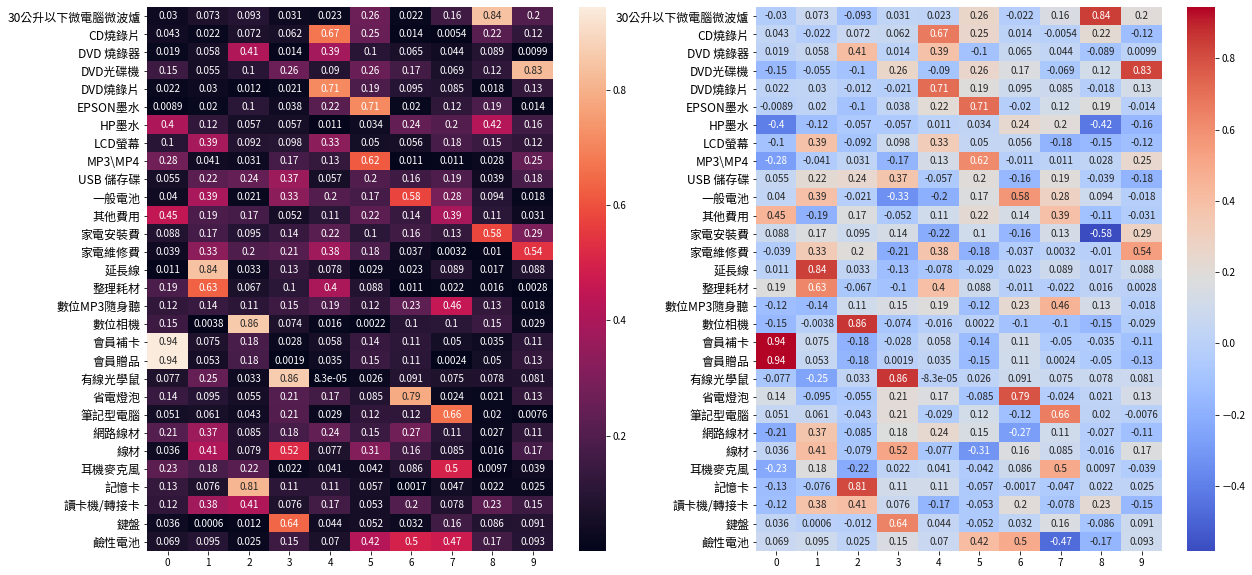

In [16]:
# 將因素視覺化：左邊為取絕對值的版本，用來判斷數值大小，右邊的圖則幫助我們判斷符號方向 #
df_fa_viz = pd.DataFrame(loadings, index=list(purchase_matrix.columns.droplevel(None)))
df_fa_viz_abs = pd.DataFrame(np.abs(loadings), index=list(purchase_matrix.columns.droplevel(None)))

fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(df_fa_viz_abs, annot=True, cmap="rocket", ax=ax1)
ax1.yaxis.set_tick_params(labelsize=12)


ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(df_fa_viz, annot=True, cmap="coolwarm", ax=ax2)
ax2.yaxis.set_tick_params(labelsize=12)

###  3. 因素轉軸
轉軸後負荷量的數值會更趨向1, -1, 或 0, 解釋上更為容易。

In [17]:
# 執行因素轉軸 #
rotator = Rotator(method='varimax')
rot_loadings = rotator.fit_transform(loadings)
pd.DataFrame(rot_loadings, index=purchase_matrix.columns.droplevel(None))

,0,1,2,3,4,5,6,7,8,9
Category,,,,,,,,,,
30公升以下微電腦微波爐,-0.060251,0.058299,-0.108264,0.041584,0.004428,0.314069,-0.008320,0.182350,0.824480,0.163030
CD燒錄片,0.053290,0.009832,0.094614,0.033760,0.682786,0.229822,0.004577,0.011328,0.221123,-0.094388
DVD 燒錄器,0.049473,0.058049,0.429845,0.008865,0.358464,-0.094666,0.046086,0.058555,-0.081656,0.073427
DVD光碟機,-0.208758,-0.090759,-0.136777,0.333103,-0.125808,0.331154,0.236524,-0.100614,0.115397,0.721366
DVD燒錄片,0.046380,0.051642,0.007812,-0.015683,0.702474,0.188643,0.086041,0.093619,-0.020326,0.173141
EPSON墨水,-0.006560,0.050556,-0.114238,0.037310,0.239819,0.711852,-0.013961,0.069960,0.161964,-0.077331
HP墨水,-0.345387,-0.092427,-0.038089,-0.067459,0.038219,0.018051,0.213481,0.246268,-0.463872,-0.173524
LCD螢幕,-0.098815,0.416262,-0.063083,0.074366,0.342007,-0.010215,0.051178,-0.155241,-0.131869,-0.089649
MP3\MP4,-0.280447,-0.028164,0.013592,-0.152997,0.134389,0.639267,0.018942,-0.015415,-0.003637,0.191685


將轉軸後的結果視覺化。

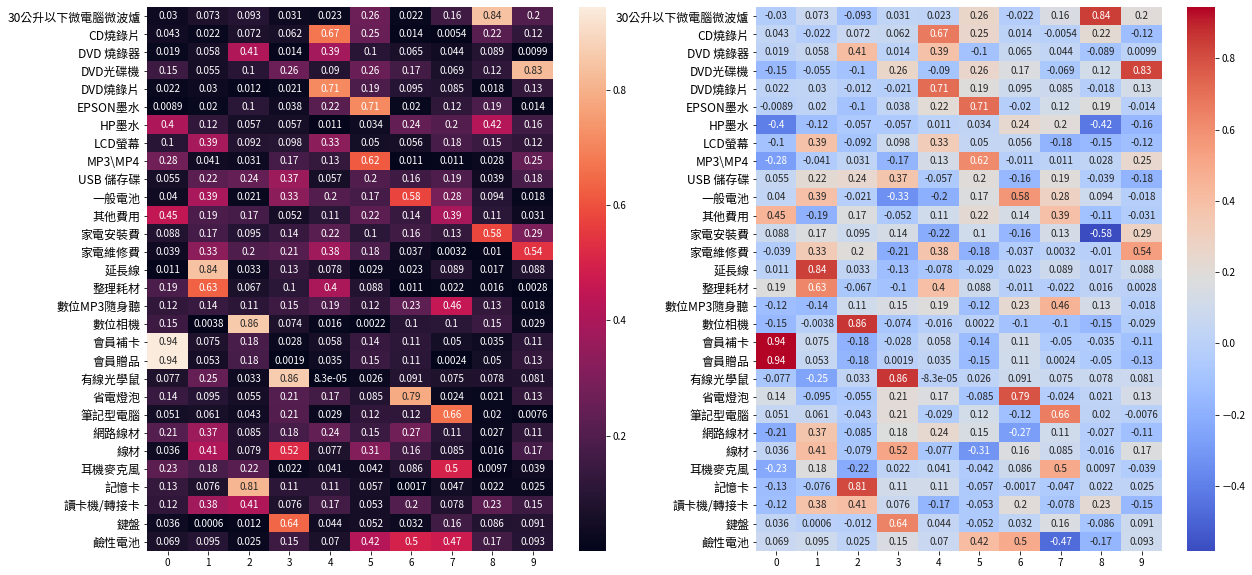

In [18]:
# 因素轉軸視覺化 #
rot_df_fa_viz = pd.DataFrame(rot_loadings, index=list(purchase_matrix.columns.droplevel(None)))
rot_df_fa_viz_abs = pd.DataFrame(np.abs(rot_loadings), index=list(purchase_matrix.columns.droplevel(None)))

fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(df_fa_viz_abs, annot=True, cmap="rocket", ax=ax1)
ax1.yaxis.set_tick_params(labelsize=12)


ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(df_fa_viz, annot=True, cmap="coolwarm", ax=ax2)
ax2.yaxis.set_tick_params(labelsize=12)

結果大抵跟沒有進行因素轉軸後的結果差不多。

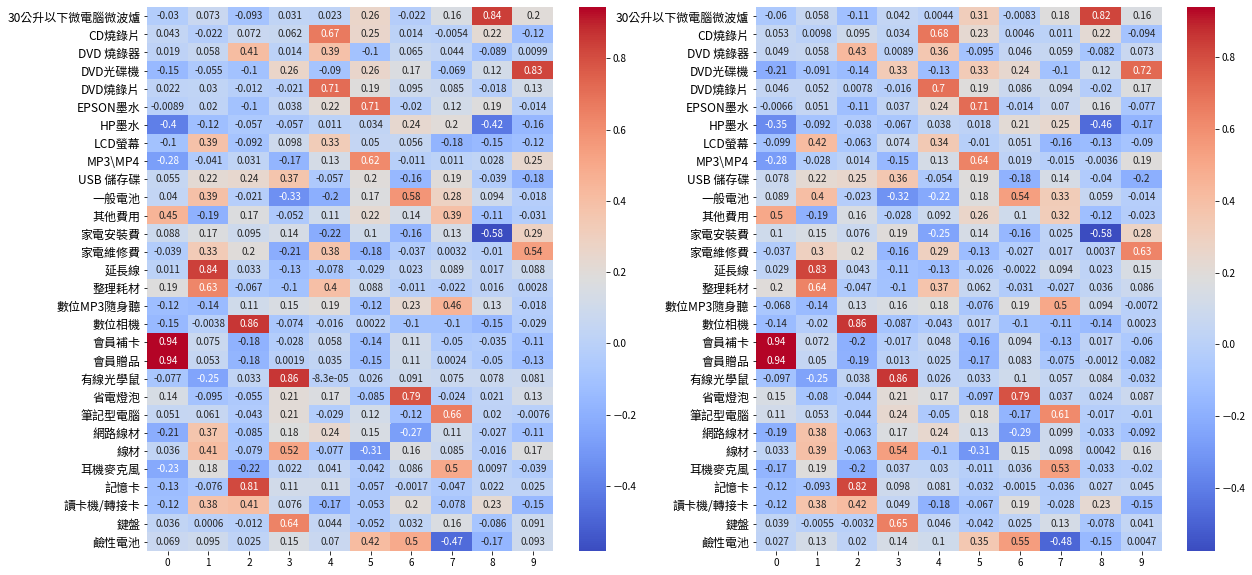

In [19]:
# 比較轉軸前後的結果 #
fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(df_fa_viz, annot=True, cmap="coolwarm", ax=ax1)
ax1.yaxis.set_tick_params(labelsize=12)


ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(rot_df_fa_viz, annot=True, cmap="coolwarm", ax=ax2)
ax2.yaxis.set_tick_params(labelsize=12)

### 【分析】購物籃分析結果
簡單整理如下：

1. 會員補卡、會員贈品、其他費用
2. 延長線、整理耗材、線材
3. DVD燒錄器、數位相機、記憶卡、讀卡機/轉接卡
4. 有線光學鼠、線材、鍵盤
5. CD燒錄片、DVD燒錄片、整理耗材
6. EPSON墨水、MP3/MP4、鹼性電池
7. 一般電池、省電燈泡、鹼性電池
8. 數位MP3隨身聽、筆記型電腦、耳機麥克風
9. 30公升以下微電腦微波爐
10. DVD光碟機、家電維修費

## 【分析】購物籃購買量
從購物籃過往的購買紀錄，探討哪個購物籃最受歡迎

In [20]:
# 整理表頭 #
purchase_matrix.columns = purchase_matrix.columns.droplevel(None)

In [21]:
pm = purchase_matrix

### 1. 所有顧客
這邊列出在資料期間，每個購物籃的購買過的人數。

前三名：微波爐 > 會員補卡&贈品 > DVD光碟機

In [22]:
# 將購物籃清單用dict存起來 #
baskets = {
    1: ['會員補卡', '會員贈品', '其他費用'], 
    2: ['延長線', '整理耗材', '線材'],
    3: ['DVD 燒錄器', '數位相機', '記憶卡', '讀卡機/轉接卡'],
    4: ['有線光學鼠', '線材', '鍵盤'],
    5: ['CD燒錄片', 'DVD燒錄片', '整理耗材'],
    6: ['EPSON墨水', 'MP3\MP4', '鹼性電池'],
    7: ['一般電池', '省電燈泡', '鹼性電池'],
    8: ['數位MP3隨身聽', '筆記型電腦', '耳機麥克風'],
    9: ['30公升以下微電腦微波爐'],
    10: ['DVD光碟機', '家電維修費']
}

In [23]:
# 定義取出購買特定購物籃消費者index的函式 #
from functools import reduce

def cond_comb(bool_series, col, data):
    return bool_series & (data[col] == 1)

def get_index(product_list, data):
    init = data[product_list[0]] == 1
    cond_comb_with_data = lambda x, y: cond_comb(x, y, data)
    return reduce(cond_comb_with_data , product_list[1:], init)

In [24]:
# 把曾購買購物籃的人數列出來 #
for i in range(10):
    print(f"購物籃 {i+1} 購買量 =",  pm[get_index(baskets[i+1], data=pm)].count()[0])

購物籃 1 購買量 = 31
購物籃 2 購買量 = 12
購物籃 3 購買量 = 8
購物籃 4 購買量 = 19
購物籃 5 購買量 = 18
購物籃 6 購買量 = 12
購物籃 7 購買量 = 7
購物籃 8 購買量 = 8
購物籃 9 購買量 = 103
購物籃 10 購買量 = 23


In [25]:
# 把購物籃的購買比例列出來 #
for i in range(10):
    print(f"購物籃 {i+1} 購買量 =",  pm[get_index(baskets[i+1], data=pm)].count()[0]/len(customers))

購物籃 1 購買量 = 0.155
購物籃 2 購買量 = 0.06
購物籃 3 購買量 = 0.04
購物籃 4 購買量 = 0.095
購物籃 5 購買量 = 0.09
購物籃 6 購買量 = 0.06
購物籃 7 購買量 = 0.035
購物籃 8 購買量 = 0.04
購物籃 9 購買量 = 0.515
購物籃 10 購買量 = 0.115


### 2. 潛在流失顧客
這邊列出在資料期間，每個購物籃的購買過的漸流失消費者人數。
 
* 前三名：微波爐 > DVD光碟機 = 燒錄片
* 購買比例：除了會員補卡&會員贈品外，其他的購買比例都比整體消費者高
    * 在購買力上超過平均的顧客水平，然而，取得的折扣優惠或價值反而低於整體水準
    * 高價值顧客卻沒有獲得相應價值的舊戶回饋，這或許是消費者逐漸靜止的原因之一

In [26]:
# 製作流失高價值客戶資料，相對應的客戶編號是直接從另一份 "3 problem exploration" 中複製貼上得來 #

ivc_id = np.array([ 284,  332,  527,  539,  637,  655,  805,  915,  977, 1006,\
                1096, 1118, 1121, 1246, 1479, 1679, 1944, 1982, 2122, 2205,\
                2220, 2239, 2307, 2377, 2549, 2747, 2787, 2800, 2814, 2843,\
                2942, 2956, 2995, 3056, 3233, 3429, 3529, 3558, 3610, 3794,\
                3855, 4515, 4608, 4687, 4785, 4866, 4922, 4967, 5239, 5348,\
                5521, 5697, 5705, 5899, 5918, 5943, 6189, 6449, 6619, 6820,\
                7005, 7854])

ivc = pm.loc[ivc_id, :]
ivc.shape                # 印出資料維度,確認想要的資料有提取出來

(62, 30)

In [27]:
# 把曾購買購物籃的流失顧客人數列出來 #
for i in range(10):
    print(f"購物籃 {i+1} 購買量 =",  ivc[get_index(baskets[i+1], data=ivc)].count()[0])

購物籃 1 購買量 = 7
購物籃 2 購買量 = 5
購物籃 3 購買量 = 4
購物籃 4 購買量 = 8
購物籃 5 購買量 = 9
購物籃 6 購買量 = 5
購物籃 7 購買量 = 4
購物籃 8 購買量 = 5
購物籃 9 購買量 = 33
購物籃 10 購買量 = 9


In [28]:
# 把購物籃的購買比例列出來 #
print("    購買比例   漸流失顧客 整體顧客")

for i in range(10):
    print(f"購物籃 {i+1} 購買量 =",  
          "{:.3f}  ".format(ivc[get_index(baskets[i+1], data=ivc)].count()[0]/len(ivc)),
         pm[get_index(baskets[i+1], data=pm)].count()[0]/len(customers))

    購買比例   漸流失顧客 整體顧客
購物籃 1 購買量 = 0.113   0.155
購物籃 2 購買量 = 0.081   0.06
購物籃 3 購買量 = 0.065   0.04
購物籃 4 購買量 = 0.129   0.095
購物籃 5 購買量 = 0.145   0.09
購物籃 6 購買量 = 0.081   0.06
購物籃 7 購買量 = 0.065   0.035
購物籃 8 購買量 = 0.081   0.04
購物籃 9 購買量 = 0.532   0.515
購物籃 10 購買量 = 0.145   0.115


### 3. 漸流失顧客購物籃
前述的方法是先找出全部顧客的購物籃後，再接著挖掘漸流失顧客的對以上10個商品組合的消費傾向。但如果我們要特別設計針對漸流失價值顧客的綑綁銷售，直接透過顧客群的消費模式去觀察購物籃會是一個更好的方法。

In [29]:
# 製作購買矩陣 #
pivot_tab_ivc = pd.pivot_table(
    transactions[transactions['ID'].isin(ivc_id)],
    values = ['Quantity'],
    columns = ['Category'],
    index = ['ID'],
    aggfunc = np.sum,
    fill_value = 0
)
purchase_matrix_ivc = (pivot_tab_ivc>0)*1

In [30]:
# 挑出>1的特徵值 #
fa_ivc = FactorAnalyzer()
fa_ivc.fit(purchase_matrix_ivc)
eigenvalues, vectors = fa_ivc.get_eigenvalues()
eigenvalues

array([5.32178148, 2.68371327, 2.14273416, 1.91033804, 1.85116809,
       1.68111816, 1.39070364, 1.26257372, 1.21009135, 1.17545735,
       1.03011356, 1.01550129, 0.87302   , 0.79000588, 0.7544405 ,
       0.69934008, 0.59971224, 0.53016046, 0.51089191, 0.39691502,
       0.37965943, 0.33843508, 0.292514  , 0.27221061, 0.23059289,
       0.2123887 , 0.17296709, 0.12216129, 0.09491569, 0.05437503])

In [31]:
# 因素分析：找出12個購物籃 #
fa_ivc = FactorAnalyzer(n_factors=12, method='principal')
fa_ivc.fit(purchase_matrix_ivc)
loadings_ivc = fa_ivc.loadings_
pd.DataFrame(loadings_ivc, index=purchase_matrix_ivc.columns.droplevel(None))

,0,1,2,3,4,5,6,7,8,9,10,11
Category,,,,,,,,,,,,
30公升以下微電腦微波爐,0.087291,-0.091984,-0.006625,0.092557,-0.460268,0.819267,-0.114331,0.012484,0.027033,0.100537,-0.159613,0.296290
CD燒錄片,0.022400,0.117833,0.027453,-0.118750,0.066669,0.786993,0.350868,0.127667,-0.056401,-0.003622,0.238751,-0.145218
DVD 燒錄器,0.101437,0.447962,0.101462,0.012793,-0.111336,0.187096,0.191095,0.126388,0.262878,0.040266,0.107951,0.183984
DVD光碟機,-0.049200,-0.092076,-0.050874,-0.121429,0.071826,0.111263,-0.149175,0.138858,-0.098451,0.026154,0.133789,0.907428
DVD燒錄片,-0.085873,-0.092090,0.120859,0.074044,0.252156,0.015822,0.243843,-0.069258,0.059374,0.053479,0.757685,0.122966
EPSON墨水,-0.055024,-0.080091,0.045331,-0.033277,0.332611,0.403331,-0.308586,0.047979,-0.069921,0.525925,0.105885,0.029762
HP墨水,-0.134059,0.004928,0.675379,-0.046750,0.127294,-0.302863,0.019041,-0.181463,-0.023944,-0.093738,0.191165,0.137785
LCD螢幕,-0.051282,-0.052710,-0.070529,0.335100,0.218525,0.104571,0.988197,0.000427,-0.098852,-0.025283,0.192964,-0.147792
MP3\MP4,0.079227,-0.065875,-0.275158,-0.039293,0.138636,0.110603,0.081906,-0.082356,0.155405,0.985718,0.004890,0.103427


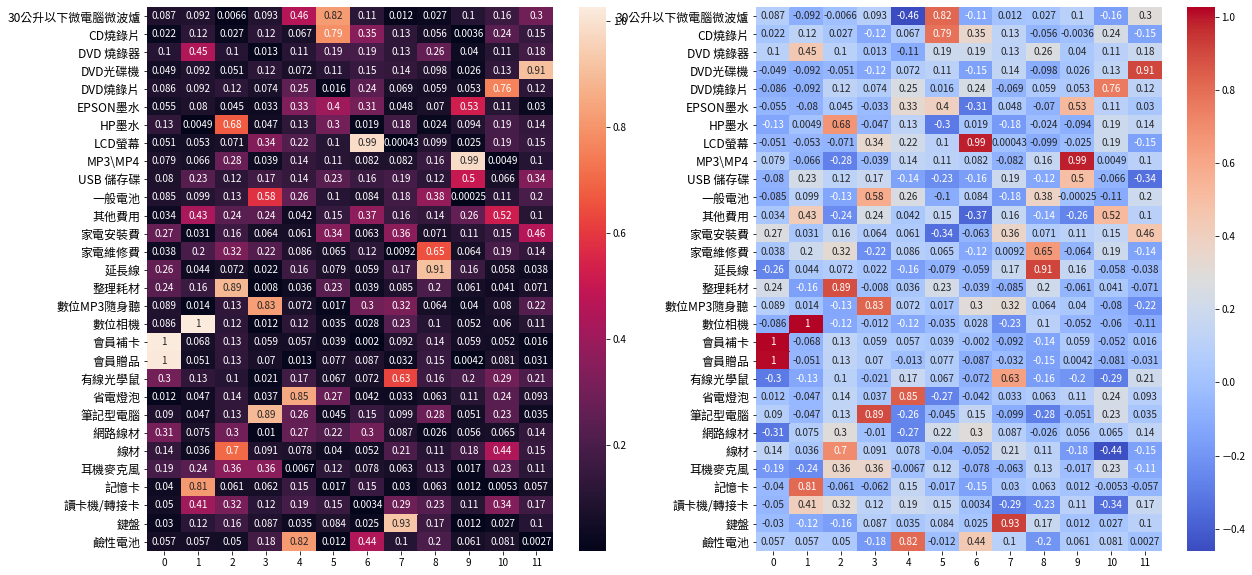

In [32]:
# 視覺化因素負荷量 #
df_fa_viz = pd.DataFrame(loadings_ivc, index=list(purchase_matrix_ivc.columns.droplevel(None)))
df_fa_viz_abs = pd.DataFrame(np.abs(loadings_ivc), index=list(purchase_matrix_ivc.columns.droplevel(None)))

fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(df_fa_viz_abs, annot=True, cmap="rocket", ax=ax1)
ax1.yaxis.set_tick_params(labelsize=12)


ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(df_fa_viz, annot=True, cmap="coolwarm", ax=ax2)
ax2.yaxis.set_tick_params(labelsize=12)

In [33]:
# 因素轉軸 #
rotator = Rotator(method='varimax')
rot_loadings_ivc = rotator.fit_transform(loadings_ivc)
pd.DataFrame(rot_loadings_ivc, index=purchase_matrix_ivc.columns.droplevel(None))

,0,1,2,3,4,5,6,7,8,9,10,11
Category,,,,,,,,,,,,
30公升以下微電腦微波爐,0.122658,-0.013645,0.035116,0.022565,-0.826821,-0.037570,0.272729,0.119567,-0.035372,0.405917,0.014317,0.296894
CD燒錄片,0.071493,0.080493,0.006611,-0.105344,-0.092937,0.272744,0.781447,0.116849,0.017922,0.275434,0.164321,0.201193
DVD 燒錄器,0.069470,0.397290,0.024800,0.070786,-0.122292,-0.225265,0.343224,0.015825,0.286121,-0.015875,0.054497,0.020191
DVD光碟機,-0.110840,-0.033399,-0.061133,-0.119741,-0.071054,-0.765351,-0.031494,0.153497,-0.164635,0.249482,0.109552,0.436829
DVD燒錄片,-0.148519,-0.240944,0.112074,0.087682,0.406080,-0.249381,0.421307,-0.312470,0.101985,0.088371,0.367628,0.060624
EPSON墨水,0.002988,-0.034731,0.051793,-0.089475,0.083443,0.003628,0.029391,0.061866,-0.017892,0.799314,0.102392,-0.061189
HP墨水,-0.147682,-0.001295,0.660183,-0.098239,0.282413,-0.253896,-0.033309,-0.201935,-0.018001,-0.163912,-0.018908,-0.038328
LCD螢幕,-0.056094,-0.123293,-0.121899,0.505901,0.370833,0.140570,0.808414,-0.088190,-0.185722,-0.214823,-0.195842,0.025686
MP3\MP4,0.058657,-0.038324,-0.406251,0.087426,0.072116,-0.209573,0.109879,-0.256707,0.145028,0.774250,-0.360352,-0.290334


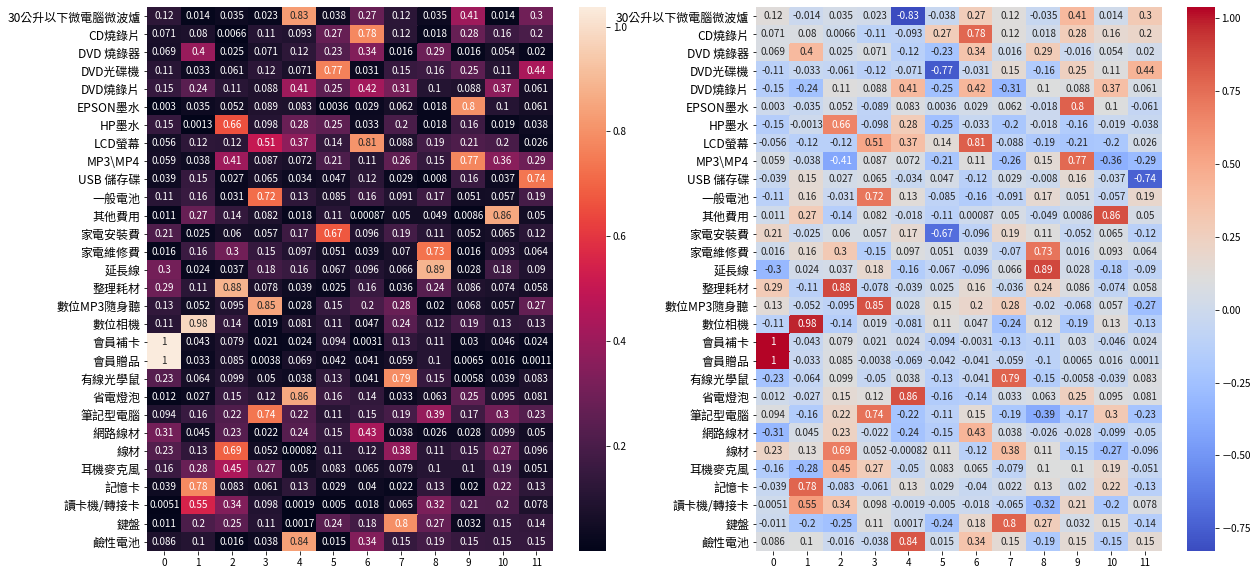

In [34]:
# 視覺化因素轉軸 #
rot_df_fa_viz = pd.DataFrame(rot_loadings_ivc, index=list(purchase_matrix_ivc.columns.droplevel(None)))
rot_df_fa_viz_abs = pd.DataFrame(np.abs(rot_loadings_ivc), index=list(purchase_matrix_ivc.columns.droplevel(None)))

fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(rot_df_fa_viz_abs, annot=True, cmap="rocket", ax=ax1)
ax1.yaxis.set_tick_params(labelsize=12)


ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(rot_df_fa_viz, annot=True, cmap="coolwarm", ax=ax2)
ax2.yaxis.set_tick_params(labelsize=12)

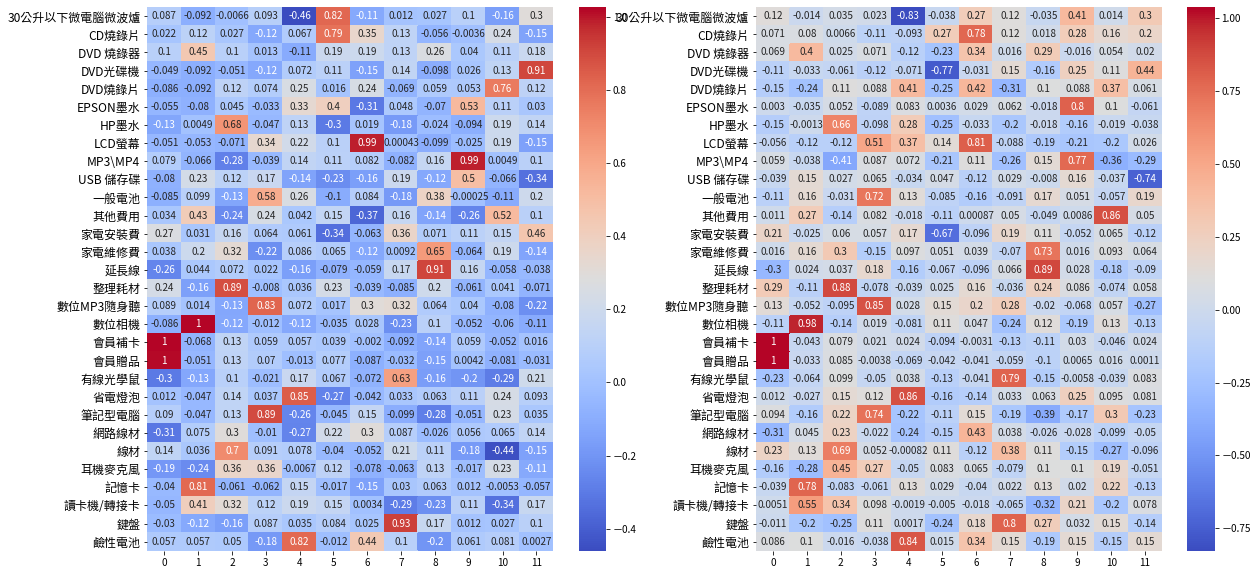

In [35]:
# 比較轉軸前後的結果 #
fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(df_fa_viz, annot=True, cmap="coolwarm", ax=ax1)
ax1.yaxis.set_tick_params(labelsize=12)


ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(rot_df_fa_viz, annot=True, cmap="coolwarm", ax=ax2)
ax2.yaxis.set_tick_params(labelsize=12)

結果：

| 購物籃編號 | 品類 |
| --- | :---: |
| 1 | 會員補卡、會員贈品 |
| 2 | 數位相機、記憶卡、讀卡機/轉接卡 |
| 3 | HP墨水、整理耗材、線材、耳機麥克風 |
| 4 | LCD螢幕、一般電池、數位MP3隨身聽、筆記型電腦 |
| 5 | DVD燒錄片、省電燈泡、鹼性電池 |
| 6 | 無特徵商品 |
| 7 | CD燒錄片、DVD燒錄片、LCD螢幕、網路線材 |
| 8 | 有線光學鼠、鍵盤 |
| 9 | 家電維修費、延長線|
| 10 | 30公升以下微電腦微波爐、EPSON墨水、MP3 |
| 11 | 其他費用 |
| 12 | DVD燒錄器|


## 消費者分群

### 1. 計算因素分數
因素分數可以幫助行銷人員了解顧客對各購物籃的需求強度：需求越大、對應購物籃的分數越高

In [36]:
# 計算因素分數 #
fa_score = fa.transform(purchase_matrix)
fa_score = pd.DataFrame(fa_score, index=purchase_matrix.index)
fa_score

,0,1,2,3,4,5,6,7,8,9
ID,,,,,,,,,,
62,0.682142,-0.115827,0.460964,1.005795,1.777418,-1.090807,-0.412775,-0.588258,-1.041601,0.102927
87,-2.123223,1.817000,3.432567,0.332282,-0.718011,-1.458903,0.363023,-0.242512,1.356061,0.950786
92,-2.013408,-0.516126,0.616672,1.274799,0.782202,1.595482,2.571560,-1.088150,0.176407,1.101638
139,1.195534,-0.959189,0.630925,0.514743,0.594465,0.024222,-0.163597,-2.026693,-1.804040,2.269250
198,2.072477,-1.676918,0.523483,-0.981494,0.091807,-1.002173,0.634892,-2.134161,0.786249,1.660597
...,...,...,...,...,...,...,...,...,...,...
8006,-0.558044,1.247931,-0.441024,-0.346170,-0.884014,-0.256107,-0.375481,-0.395189,-0.071341,-1.017784
8059,-0.693541,0.786471,-0.690126,-0.666852,-0.700997,1.055851,-0.593684,-0.273975,-0.607189,-0.684352
8141,-0.866665,1.475150,-0.109153,-0.231514,-0.788282,-1.169347,-0.676785,0.164682,0.175974,-0.847851


#### 所有消費者
* 找出每一個人消費傾向最大的購物籃，並計算所有購物籃獲得「最大消費傾向」的個數。
* 前三名的購物籃是：編號2、編號7、編號6
    * 延長線、整理耗材、線材 > 一般電池、省電燈泡、鹼性電池 >EPSON墨水、MP3/MP4、鹼性電池

In [37]:
# 顯示購物籃為因素分數最大購物籃的次數 #
individual_max_fa_score = fa_score.apply(lambda x: list(x).index(max(x)), axis=1)
individual_max_fa_score.groupby(individual_max_fa_score).count()

0    13
1    39
2    16
3    20
4    16
5    25
6    26
7    20
8    14
9    11
dtype: int64

#### 漸流失消費者
* 找出每一個漸流失顧客的消費傾向最大購物籃，並計算所有購物籃獲得「最大消費傾向」的個數。
* 前三名的購物籃是：編號1、編號4、編號9
    * 會員補卡、會員贈品、其他費用 > 有線光學鼠、線材、鍵盤 > 30公升以下微電腦微波爐

In [38]:
# 顯示所有購物籃為因素最大購物籃的次數 #
ivc_max_fa_score = fa_score.loc[ivc_id, :].apply(lambda x: list(x).index(max(x)), axis=1)
ivc_max_fa_score.groupby(individual_max_fa_score).count()

0    9
1    6
2    6
3    9
4    7
5    3
6    6
7    5
8    8
9    3
dtype: int64

#### 漸流失消費購物籃
* 找出每一個漸流失顧客的消費傾向最大購物籃，並計算漸流失消費購物籃獲得「最大消費傾向」的個數。
* 前三名的購物籃是：編號1、編號11、編號12
    * 優惠相關的會員補卡與會員贈品 > 其他費用 > DVD燒錄器

In [39]:
# 計算因素分數 #
fa_score_ivc = fa_ivc.transform(purchase_matrix_ivc)
fa_score_ivc = pd.DataFrame(fa_score_ivc, index=purchase_matrix_ivc.index)
fa_score_ivc

,0,1,2,3,4,5,6,7,8,9,10,11
ID,,,,,,,,,,,,
284,-0.931067,0.238708,-0.078891,0.812276,0.924278,2.172644,1.276505,0.232862,2.136511,2.359411,1.890383,1.280609
332,-0.481129,1.597145,-0.021740,-0.386782,1.895641,2.563296,1.564600,1.225979,2.775899,1.012976,1.170343,1.152519
527,-0.763260,0.214849,-1.271077,1.582541,-0.568158,0.439903,-0.819226,-0.687695,-1.089671,-0.124384,-1.093563,0.247291
539,-0.981459,0.611073,0.136494,0.691594,2.099784,0.282634,-2.082277,1.228308,1.282091,1.211342,1.799426,1.812058
637,-1.372517,1.945914,-1.158940,-0.942105,-0.577077,0.443337,-0.344314,-0.383667,-0.202077,2.118593,-0.422509,-0.708731
...,...,...,...,...,...,...,...,...,...,...,...,...
6449,1.068516,-0.480414,-0.434320,0.754896,-1.093342,0.448632,-0.285267,0.357772,-0.575661,-0.959606,-0.937993,-1.032688
6619,1.681848,-0.972755,1.441236,-0.796640,-0.415624,-0.354945,0.329993,0.956262,-0.732904,-0.928703,-1.087725,-0.411416
6820,-0.621551,-1.012509,-1.299645,-0.597235,-0.669103,-0.322386,-0.744745,-1.123858,-0.521410,-0.281810,-0.373324,1.271618


In [40]:
# 顯示各漸流失購物籃為因素最大購物籃的次數 #
individual_max_fa_score_ivc = fa_score_ivc.apply(lambda x: list(x).index(max(x)), axis=1)
individual_max_fa_score_ivc.groupby(individual_max_fa_score_ivc).count()

0     14
1      4
2      3
3      3
4      5
5      5
6      5
7      1
8      5
9      4
10     7
11     6
dtype: int64

### 2. 集群分析
透過集群方法，把顧客分為數個市場。

我們可以使用 (1)Ward method (2) K-means Clustering

In [41]:
from sklearn.cluster import AgglomerativeClustering, KMeans

# Ward Method: 效果不太好
# agglo_clusters = AgglomerativeClustering(n_clusters=5, linkage="ward").fit(fa_score)
# pd.DataFrame({'label':agglo_clusters.labels_}, index=purchase_matrix.index).groupby('label')['label'].count()

In [42]:
# 設定集群中心起始值：用來重現結果 #
good_init = np.array([[ 1.01219463, -0.82716759,  0.23406838,  0.18124711,  0.88845558,
        -0.23956035, -0.36962617, -0.26166458, -0.12905706,  0.90195405],
       [-0.39557344,  0.89528203, -0.12761694, -0.02788751, -0.51150922,
        -0.73075561, -0.4567193 ,  0.60304648,  0.05450269, -0.53618847],
       [-0.45091696,  0.20481013, -0.4436964 , -0.41875756, -0.35885652,
         0.53488823, -0.25840355, -0.15348873, -0.39626189, -0.49807011],
       [-0.10871846, -0.96101984, -0.15075234,  0.02975947,  0.42572198,
         0.99072683,  1.5049414 , -1.09465225,  0.82532108,  0.52514663],
       [ 0.48724977, -0.24663264,  1.52267202,  1.20149356,  0.26423514,
        -0.64728354,  1.58631079,  0.61694988,  1.01350878,  0.72773654]])

In [43]:
# K-means clustering #
k_means_clusters = KMeans(n_clusters=5, n_init=1, init=good_init).fit(fa_score)
pd.DataFrame({'label':k_means_clusters.labels_}, index=purchase_matrix.index).groupby('label')['label'].count()

label
0    43
1    44
2    77
3    15
4    21
Name: label, dtype: int64

最後我們要把集群結果加入原始資料中。

In [44]:
# 把集群結果與顧客資料合併 #
clusters = k_means_clusters

customers_temp = customers.copy()
customers_temp['Cluster'] = clusters.labels_
customers_temp.head()

,客戶ID,Gender,Age,Zipcode,Area,AgeLevel,Cluster
0,3596,男,37,247,北區,35-44歲,0
1,1729,女,29,112,北區,25-34歲,4
2,2036,男,30,237,北區,25-34歲,3
3,1686,男,34,234,北區,25-34歲,0
4,5943,女,48,802,南區,45-54歲,0


檢視每個分群對購物籃的消費傾向。因為每個分群裡面包含許多顧客，以分群的中心作為每個群集的代表點。

**簡單統整一下各分群的商品組合，以此為分群命名**
* 組別1：DVD燒錄需求 + 優惠 = DVD需求群
* 組別2：整理耗材需求 + 3C = 耗材+3C群
* 組別3：EPSON 墨水匣 + MP3 + 線材 = 墨水匣 + MP3群
* 組別4&5：廣泛消費 = 廣泛消費群(I)&(II)

In [45]:
# 檢視集群中心 #
pd.DataFrame(clusters.cluster_centers_)

,0,1,2,3,4,5,6,7,8,9
0,1.012195,-0.827168,0.234068,0.181247,0.888456,-0.239560,-0.369626,-0.261665,-0.129057,0.901954
1,-0.395573,0.895282,-0.127617,-0.027888,-0.511509,-0.730756,-0.456719,0.603046,0.054503,-0.536188
2,-0.450917,0.204810,-0.443696,-0.418758,-0.358857,0.534888,-0.258404,-0.153489,-0.396262,-0.498070
3,-0.108718,-0.961020,-0.150752,0.029759,0.425722,0.990727,1.504941,-1.094652,0.825321,0.525147
4,0.487250,-0.246633,1.522672,1.201494,0.264235,-0.647284,1.586311,0.616950,1.013509,0.727737


#### 【分析】集群後ARFM分析
為了跟將ARFM維度與集群結果合併比較，我們必須先將RFM資料讀入，再將其與集群欄位合併

In [46]:
# 載入資料 #
rfm_data = pd.read_csv("_rfm_data.csv", index_col=0)
rfm_data.head()

,客戶ID,Gender,Age,Zipcode,Area,FirstPurchase,NPurchase,Reccency,Frequency,MonetaryValue,TotalAmount,CAI,Active,LowReccency,HighFrequency,HighMonetaryValue,ActivenessCategory
0,3596,男,37,247,北區,2006-03-21,28,7,13,6922.076923,89987,0.323937,True,True,True,True,Top 20%
1,1729,女,29,112,北區,2006-04-19,4,155,3,6416.666667,19250,0.329051,True,False,False,True,Top 20%
2,2036,男,30,237,北區,2006-07-29,4,327,4,1082.250000,4329,-0.141753,False,False,False,False,Bottom 20%
3,1686,男,34,234,北區,2006-01-26,172,3,78,6419.870130,494330,0.375476,True,True,True,True,Top 20%
4,5943,女,48,802,南區,2006-12-24,12,43,7,6005.714286,42040,-0.387013,False,True,True,True,Bottom 20%


In [47]:
# 合併資料 #
rfm_data = rfm_data.merge(customers_temp[['客戶ID','AgeLevel','Cluster']], on='客戶ID')
rfm_data.head()

,客戶ID,Gender,Age,Zipcode,Area,FirstPurchase,NPurchase,Reccency,Frequency,MonetaryValue,TotalAmount,CAI,Active,LowReccency,HighFrequency,HighMonetaryValue,ActivenessCategory,AgeLevel,Cluster
0,3596,男,37,247,北區,2006-03-21,28,7,13,6922.076923,89987,0.323937,True,True,True,True,Top 20%,35-44歲,0
1,1729,女,29,112,北區,2006-04-19,4,155,3,6416.666667,19250,0.329051,True,False,False,True,Top 20%,25-34歲,4
2,2036,男,30,237,北區,2006-07-29,4,327,4,1082.250000,4329,-0.141753,False,False,False,False,Bottom 20%,25-34歲,3
3,1686,男,34,234,北區,2006-01-26,172,3,78,6419.870130,494330,0.375476,True,True,True,True,Top 20%,25-34歲,0
4,5943,女,48,802,南區,2006-12-24,12,43,7,6005.714286,42040,-0.387013,False,True,True,True,Bottom 20%,45-54歲,0


**分群結果的ARFM敘述統計結果如下**
* DVD需求群：消費總金額最多
* 耗材+3C群：RFM表現不佳，但CAI大於0
* 墨水匣+MP3群：RFM表現平均。CAI略小於0
* 廣泛消費群(I)：距今消費天數最短、消費頻次最高
* 廣泛消費群(II)：平均消費金額最高、CAI最高

In [48]:
# 敘述統計 #
with pd.option_context('display.max_rows', 1000, 'display.precision', 3):
    display(rfm_data[["Reccency", "Frequency", "MonetaryValue", "TotalAmount", "CAI", "Cluster"]].groupby('Cluster').describe().T)

Cluster                       0           1           2           3          4
Reccency      count      42.000      44.000      77.000      14.000     21.000
              mean       80.238      85.000      78.948      68.929    123.714
              std       101.660      89.117      79.860      84.128     69.602
              min         1.000       2.000       1.000       6.000     21.000
              25%        22.250      22.000      22.000      25.250     43.000
              50%        47.000      44.000      44.000      44.500    150.000
              75%        83.250     169.250     112.000      58.750    171.000
              max       514.000     371.000     339.000     327.000    253.000
Frequency     count      42.000      44.000      77.000      14.000     21.000
              mean       11.429       7.568       8.961      13.500      5.762
              std        14.127       7.975      10.276      18.883      4.146
              min         1.000       1.000       1.000       1.000      1.000
              25%         4.000       2.000       3.000       4.250      3.000
              50%         6.500       3.000       6.000       9.000      4.000
              75%        12.750      12.000      11.000      11.750      8.000
              max        78.000      39.000      75.000      73.000     16.000
MonetaryValue count      42.000      44.000      77.000      14.000     21.000
              mean     2351.734    2293.636    2455.157    2317.227   2781.005
              std      2231.302    1935.360    2277.391    1642.210   3354.534
              min       270.833     275.667      87.000     495.545    320.000
              25%       876.604     894.778     961.947    1201.898   1109.750
              50%      1562.900    2043.002    1799.000    1787.232   1513.875
              75%      3229.083    3112.625    3034.000    2992.450   3053.833
              max     10812.333    8880.500   11730.000    6955.667  14754.500
TotalAmount   count      42.000      44.000      77.000      14.000     21.000
              mean    36575.619   19863.114   23315.545   23598.357  14862.952
              std     82863.683   34455.734   50084.273   31080.505  15682.037
              min       400.000     400.000     174.000    2641.000    320.000
              25%      2854.250    2725.250    3818.000    5785.500   4439.000
              50%      8735.000    7723.500   12850.000   13362.500  11327.000
              75%     28723.250   25575.250   26000.000   23970.250  18323.000
              max    494330.000  209317.000  424905.000  115993.000  54743.000
CAI           count      38.000      38.000      67.000      12.000     17.000
              mean        0.075       0.030      -0.006      -0.028      0.132
              std         0.239       0.140       0.172       0.200      0.188
              min        -0.481      -0.270      -0.326      -0.277     -0.209
              25%        -0.126      -0.040      -0.116      -0.147      0.071
              50%         0.011       0.000       0.000      -0.097      0.147
              75%         0.307       0.070       0.115       0.013      0.244
              max         0.540       0.358       0.376       0.387      0.448

**假設檢定**

雖然我們現在分成5個市場區隔，彼此之間在RFM與CAI有所差異。但這個差異有可能只是抽樣的隨機性造成的，在母體上並沒有這個差別，因此我們可以透過F-test去檢驗各個項目平均值的是否真的存在落差。

商業應用上我們可以容許一個比較寬鬆的顯著水準alpha=0.3，在F-test下顯著的項目有「距今消費天數」、「消費頻次」以及CAI。根本而言，這三個變數都反映了消費的間隔時間（interpurchase time）。

In [49]:
# 定義一個函式，用來取出對應資料來進行f-test #

from scipy.stats import f_oneway

def f_test(data, variable, groupby='Cluster', log_value=False):
    f_data = []
    for _, idx in data.groupby(groupby).groups.items():
        section = (data.loc[idx, :])[variable].dropna()
        
        if log_value == True:
            section = np.log(section)
        
        section = list(section)
        f_data.append(section)
    return f_oneway(*f_data)

In [50]:
# 對五個項目進行 f-test 的結果 #
for var in ["Reccency", "Frequency", "MonetaryValue", "TotalAmount", "CAI"]:
    if var != 'CAI':
        print(var, ':', f_test(data=rfm_data, variable=var, log_value=True))
    else:
        print(var, ':', f_test(data=rfm_data, variable=var, log_value=False))


Reccency : F_onewayResult(statistic=2.132304662625693, pvalue=0.07832079976306769)
Frequency : F_onewayResult(statistic=1.3695952663065125, pvalue=0.24595846734396193)
MonetaryValue : F_onewayResult(statistic=0.11294205788974489, pvalue=0.9778605108553821)
TotalAmount : F_onewayResult(statistic=0.6620563093426206, pvalue=0.6190843286509399)
CAI : F_onewayResult(statistic=2.754622841701269, pvalue=0.029726931748169757)


### 3. 卡方分析
卡方分析(chi2 independency test) 可以用來檢定二個類別變量的關聯程度。放在消費者集群的脈絡下來看，我們可以藉此觀察各分群間是否在人口統計變量上有所差異。如果有的話，我們就可以利用某些人口統計變數來追溯出我們的目標市場。

In [51]:
# 載入卡方檢定函式 #
from scipy.stats import chi2_contingency

先透過樞紐分析表功能建立列聯表，在接著利用`chi2_contingency`計算卡方統計量和對應的p-value

因為kmeans clustering 有一定隨機性，所以我不斷嘗試直到找到顯著的分群為止，前面的`good_init`就是重現這個分群結果的預設值。

表格中間呈現的是條件機率，最底列呈現則是該集群的邊際機率

In [52]:
# 進行卡方檢定，並顯示檢定結果和機率分配表格 #
categorical_var_list = ['Gender', 'AgeLevel', 'Area']

display(pd.pivot_table(customers_temp, columns='Cluster', values='客戶ID', aggfunc='count', fill_value=0))
print("\n")

for var in categorical_var_list:
    
    # 製作列聯表
    pivot_tab_temp = pd.pivot_table(customers_temp, columns='Cluster', index=var,
                                    values='客戶ID', aggfunc='count', fill_value=0)
    
    # 卡方檢定
    chi2, p_value, _, _ = chi2_contingency(pivot_tab_temp)
    
    # 製作呈現用的表格
    pivot_tab_temp = pd.pivot_table(customers_temp, columns='Cluster', index=var,
                                    values='客戶ID', aggfunc='count', fill_value=0,
                                    margins=True)
    
    # 製作機率分配表格
    dist = {}
    for id, row in pivot_tab_temp.iterrows():
        dist[id] = row/row.iloc[-1]
    pivot_tab_dist = pd.DataFrame(dist).T
    
    with pd.option_context('display.precision', 3):
        print("----------")
        print(var, "  (Chi2, p_value) = ({:.3f}, {:.3f})".format(chi2, p_value))
        display(pivot_tab_dist)
        print("\n")


Cluster,0,1,2,3,4
客戶ID,43,44,77,15,21




----------
Gender   (Chi2, p_value) = (10.996, 0.027)


Cluster,0,1,2,3,4,All
女,0.192,0.256,0.333,0.038,0.179,1.0
男,0.230,0.197,0.418,0.098,0.057,1.0
All,0.215,0.220,0.385,0.075,0.105,1.0




----------
AgeLevel   (Chi2, p_value) = (16.303, 0.698)


Cluster,0,1,2,3,4,All
25-34歲,0.220,0.220,0.320,0.140,0.100,1.0
35-44歲,0.167,0.222,0.417,0.042,0.153,1.0
45-54歲,0.205,0.256,0.410,0.051,0.077,1.0
55-64歲,0.231,0.154,0.462,0.077,0.077,1.0
65歲以上,0.500,0.250,0.125,0.125,0.000,1.0
未滿25歲,0.400,0.200,0.400,0.000,0.000,1.0
All,0.215,0.220,0.385,0.075,0.105,1.0




----------
Area   (Chi2, p_value) = (22.130, 0.139)


Cluster,0,1,2,3,4,All
中區,0.282,0.308,0.256,0.051,0.103,1.0
北區,0.175,0.223,0.427,0.058,0.117,1.0
南區,0.260,0.160,0.380,0.100,0.100,1.0
外島地區,0.000,0.000,0.000,1.000,0.000,1.0
東區,0.143,0.143,0.571,0.143,0.000,1.0
All,0.215,0.220,0.385,0.075,0.105,1.0


設定顯著水準 α = 0.15，則在分群結果下，人口統計變數中的「性別」、「地區」為顯著變數，可用以界定消費者輪廓。年齡變數就目前的資料，尚未與分群變數具備顯著的關聯性。

**顧客輪廓整理如下**
* DVD需求群：男性、居住 中區/南區
* 耗材+3C群：女性、居住 北區/中區
* 墨水匣+MP3群：男性、居住 北區/東區
* 廣泛消費群(I)：男性、居住 南區/東區/離島地區
* 廣泛消費群(II)：女性、居住 北區

### 4. 變異數分析
變異數分析就是F-test，但現在我們是在每個分群間考慮不同的人口統計變數，捉對讓二二一組去比較他們平均消費金額的平均值。如果有差異，我們就可以聲稱在這樣的分群下，利用人口統計變數區分消費者，能給公司帶來獲利上的差異。

In [53]:
# 定義函式用來前處理資料然後進行檢定 #
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

def anova(data, variable, profit_index, alpha):
    print(f"{variable} - {profit_index}\n")

    for clu in range(5):
        temp_data = data.groupby('Cluster').get_group(clu)
        mc = MultiComparison(temp_data[profit_index], temp_data[variable])
        tkresult = mc.tukeyhsd(alpha)
        print("cluster =", clu+1, "\n")
        print(tkresult)
        print("\n")

In [54]:
# 因為消費平均金額不是常態分布，我們取log讓他接近常態一些 #
rfm_data['LogMonetaryValue'] = np.log(rfm_data.MonetaryValue)

In [55]:
# 取人口統計變數 = 性別 來檢定獲利上的差異 #
profit_index = 'LogMonetaryValue'
variable = 'Gender'

anova(rfm_data, variable, profit_index, alpha=0.3)

Gender - LogMonetaryValue

cluster = 1 

Multiple Comparison of Means - Tukey HSD, FWER=0.30
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     女      男  -0.0727 0.8169 -0.3886 0.2432  False
---------------------------------------------------


cluster = 2 

Multiple Comparison of Means - Tukey HSD, FWER=0.30
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     女      男  -0.0015   0.9 -0.2844 0.2815  False
--------------------------------------------------


cluster = 3 

Multiple Comparison of Means - Tukey HSD, FWER=0.30
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     女      男    -0.11 0.6271 -0.3384 0.1185  False
---------------------------------------------------


cluster = 4 

Multiple Comparison of Means - Tukey HSD, FWER=0.30
group1 group2 meandiff p-adj   lower  upper  reject
-------------------------------

In [56]:
# 取人口統計變數 = 年齡層 來檢定獲利上的差異 #
profit_index = 'LogMonetaryValue'
variable = 'AgeLevel'

anova(rfm_data, variable, profit_index, alpha=0.3)

AgeLevel - LogMonetaryValue

cluster = 1 

Multiple Comparison of Means - Tukey HSD, FWER=0.30
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
25-34歲 35-44歲  -0.1078    0.9 -0.9445  0.729  False
25-34歲 45-54歲  -0.1295    0.9 -1.0987 0.8398  False
25-34歲 55-64歲  -0.2535    0.9 -1.2709 0.7639  False
25-34歲  65歲以上  -0.7093 0.7658 -1.8798 0.4611  False
25-34歲  未滿25歲  -0.3804    0.9 -1.9213 1.1605  False
35-44歲 45-54歲  -0.0217    0.9 -0.9751 0.9317  False
35-44歲 55-64歲  -0.1457    0.9  -1.148 0.8566  False
35-44歲  65歲以上  -0.6016 0.8673 -1.7589 0.5558  False
35-44歲  未滿25歲  -0.2726    0.9 -1.8037 1.2584  False
45-54歲 55-64歲  -0.1241    0.9 -1.2393 0.9912  False
45-54歲  65歲以上  -0.5799    0.9 -1.8363 0.6766  False
45-54歲  未滿25歲   -0.251    0.9 -1.8582 1.3563  False
55-64歲  65歲以上  -0.4558    0.9 -1.7498 0.8381  False
55-64歲  未滿25歲  -0.1269    0.9 -1.7636 1.5098  False
 65歲以上  未滿25歲   0.3289    0.9 -1.4071  2.065  False
---------------------

In [57]:
# 取人口統計變數 = 地區 來檢定獲利上的差異 #
profit_index = 'LogMonetaryValue'
variable = 'Area'

anova(rfm_data, variable, profit_index, alpha=0.3)

Area - LogMonetaryValue

cluster = 1 

Multiple Comparison of Means - Tukey HSD, FWER=0.30
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    中區     北區   1.1311 0.0038   0.585 1.6771   True
    中區     南區   0.8324 0.0669  0.2542 1.4105   True
    中區     東區   1.8161 0.1444  0.3422   3.29   True
    北區     南區  -0.2987 0.7158 -0.8187 0.2212  False
    北區     東區    0.685 0.8167  -0.767 2.1371  False
    南區     東區   0.9838 0.6203 -0.4807 2.4482  False
---------------------------------------------------


cluster = 2 

Multiple Comparison of Means - Tukey HSD, FWER=0.30
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    中區     北區   0.3921 0.5722 -0.1516 0.9359  False
    中區     南區  -0.1765    0.9 -0.8735 0.5205  False
    中區     東區   -0.975 0.6779 -2.5644 0.6144  False
    北區     南區  -0.5686 0.3852 -1.1954 0.0581  False
    北區     東區  -1.3671  0.416  -2.927 0.1927  False
    南區   

**結論**：設定顯著水準 α = 0.15，進行ANOVA分析，結果可見表4.7。目前的資料只能在「性別」變數中的分群5其中男女的比較，以及「地區」變數中的分群1，其中中部對北部、南部、東部的比較，呈現顯著的結果。

就目前的資料上：我們在實際執行行銷活動時，在第5群中廣泛消費群中才區分性別，或者在第1群DVD需求群僅劃分為中部和其他地區。減少不必要的市場區隔，節省行銷活動的成本。

### 5. 漸流失客戶與集群分析結果

In [58]:
# 顯示漸流失客戶在各集群中的人數 #
customers_temp[customers_temp["客戶ID"].isin(ivc_id)].groupby('Cluster')['客戶ID'].count()

Cluster
0    11
1    11
2    31
3     7
4     2
Name: 客戶ID, dtype: int64

In [59]:
# 各集群所含流失客戶的比例 #
customers_temp[customers_temp["客戶ID"].isin(ivc_id)].groupby('Cluster')['客戶ID'].count()/62

Cluster
0    0.177419
1    0.177419
2    0.500000
3    0.112903
4    0.032258
Name: 客戶ID, dtype: float64

**結論**
* 墨水匣+MP3/MP4 群集包含了最多的漸流失顧客。
    * 但是該分群所設定的購物籃，並非為漸流失顧客所設計的商品組合。
* 建議投入第二大的DVD需求群，因為該群的購物籃包含了會員補卡和DVD燒錄器(漸流失顧客群內找到的前三名購物組合之二)，反而更有可能吸引消費活動逐漸靜止的消費者